Plus 20K from dair-ai dataset

https://huggingface.co/datasets/dair-ai/emotion


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import string
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
# from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM, Dense, SpatialDropout1D, Bidirectional
# from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split


In [2]:
df20k = pd.read_csv("/content/drive/MyDrive/NLP_GLOVE_DAIR/datasets/all.csv")
df410k = pd.read_parquet("/content/drive/MyDrive/NLP_GLOVE_DAIR/datasets/train-unsplit.parquet")

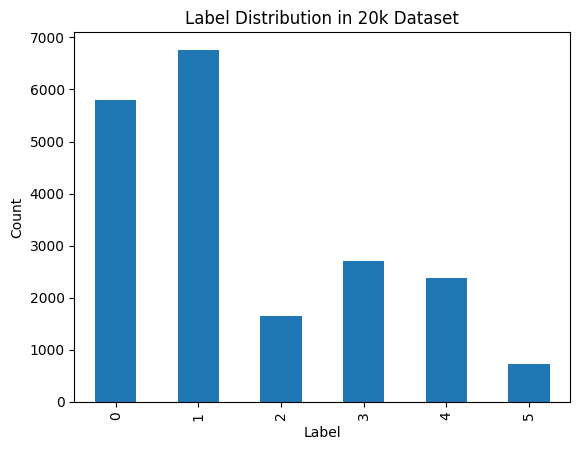

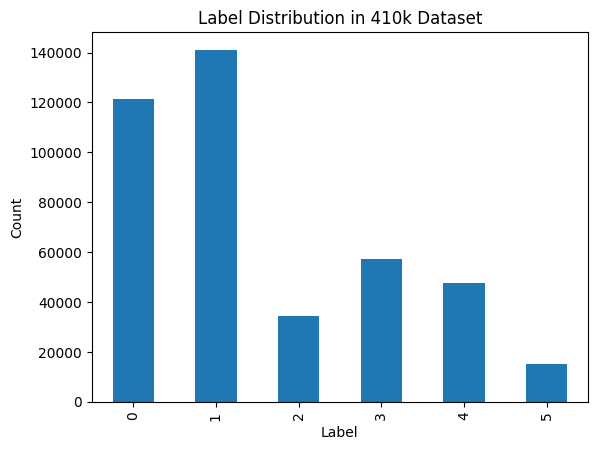

In [ ]:
df20k['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Label Distribution in 20k Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()
df410k['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Label Distribution in 410k Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [3]:
target_count = 14500
balanced_additions = []

for label in range(6):  # assuming labels are 0–5
    current_count = len(df20k[df20k['label'] == label])
    needed = target_count - current_count

    if needed > 0:
        # Select 'needed' samples from df_410k that match the label
        candidates = df410k[df410k['label'] == label]

        # Avoid adding samples already in df_20k (by text)
        candidates = candidates[~candidates['text'].isin(df20k['text'])]

        # Randomly sample from remaining candidates
        sampled = candidates.sample(n=min(needed, len(candidates)), random_state=42)

        balanced_additions.append(sampled)


In [4]:
df_augmented = pd.concat([df20k] + balanced_additions, ignore_index=True)
df_augmented = df_augmented.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffl

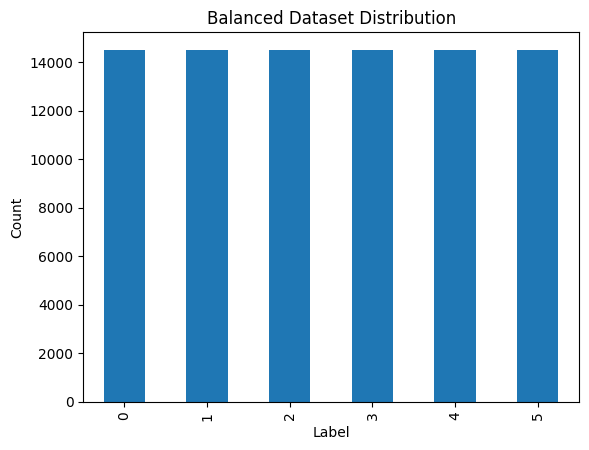

In [5]:
df_augmented['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Balanced Dataset Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [6]:
# df_augmented = df_augmented.drop_duplicates(subset='text')

# df_augmented.duplicated().sum()
df_augmented.isnull().sum()

,0
text,0
label,0


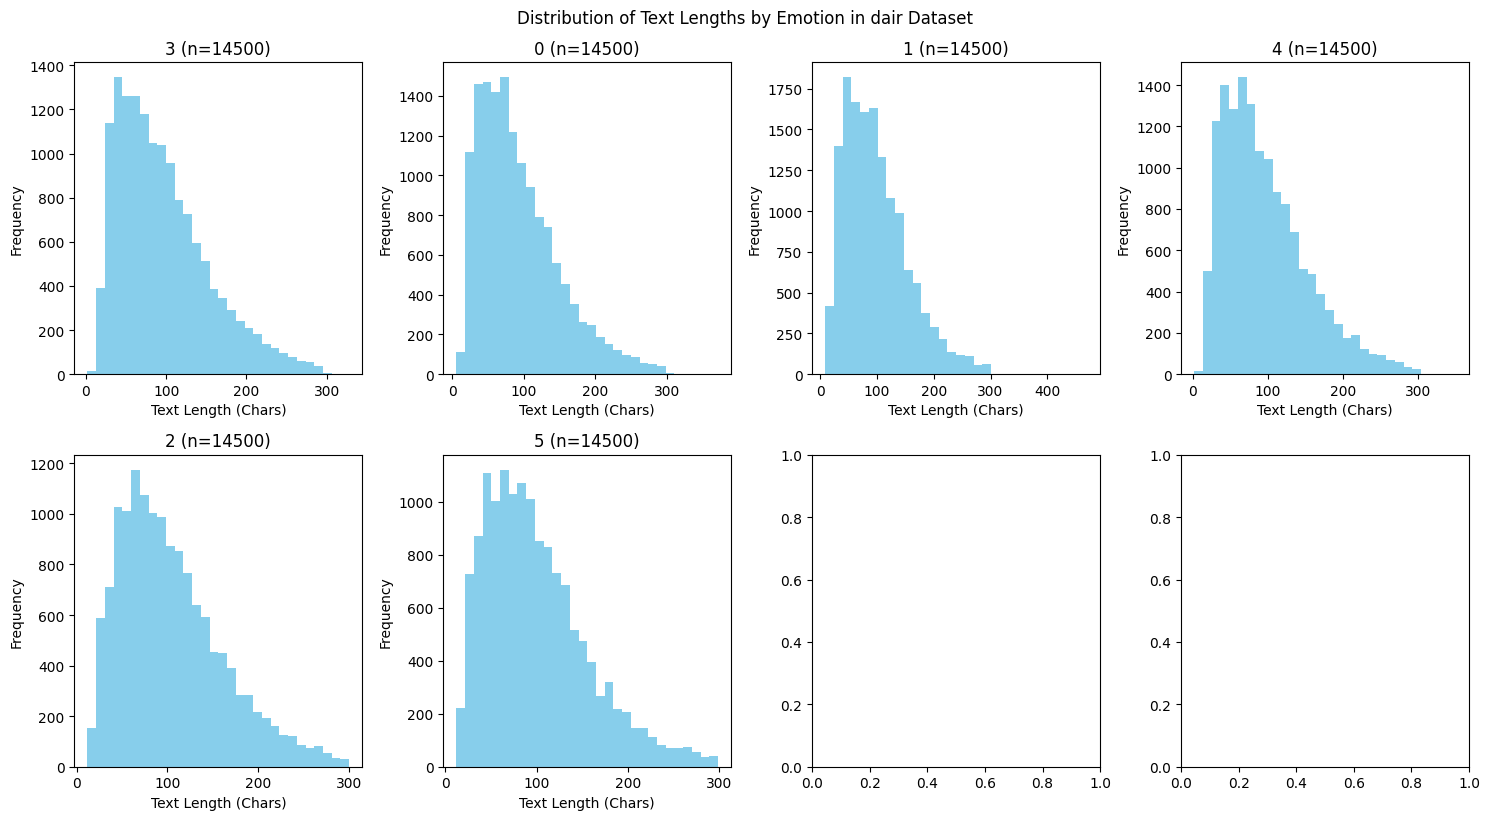

In [ ]:
# Get the list of unique emotions in the dataset
emotions = df_augmented['label'].unique()

# Set up subplots (adjust layout as needed)
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # 2 rows, 4 columns (for 7 emotions)
axes = axes.ravel()  # Flatten the axes array for easy iteration

# Plot histogram of text lengths for each emotion
for i, emotion in enumerate(emotions):
    # Filter text by emotion and compute lengths
    text_lengths = df_augmented[df_augmented['label'] == emotion]['text'].str.len()

    # Plot histogram
    axes[i].hist(text_lengths, color='skyblue', bins=30)
    axes[i].set_title(f'{emotion} (n={len(text_lengths)})')
    axes[i].set_xlabel('Text Length (Chars)')
    axes[i].set_ylabel('Frequency')

# Adjust layout and show
plt.tight_layout()
fig.suptitle('Distribution of Text Lengths by Emotion in dair Dataset', y=1.02)
plt.show()

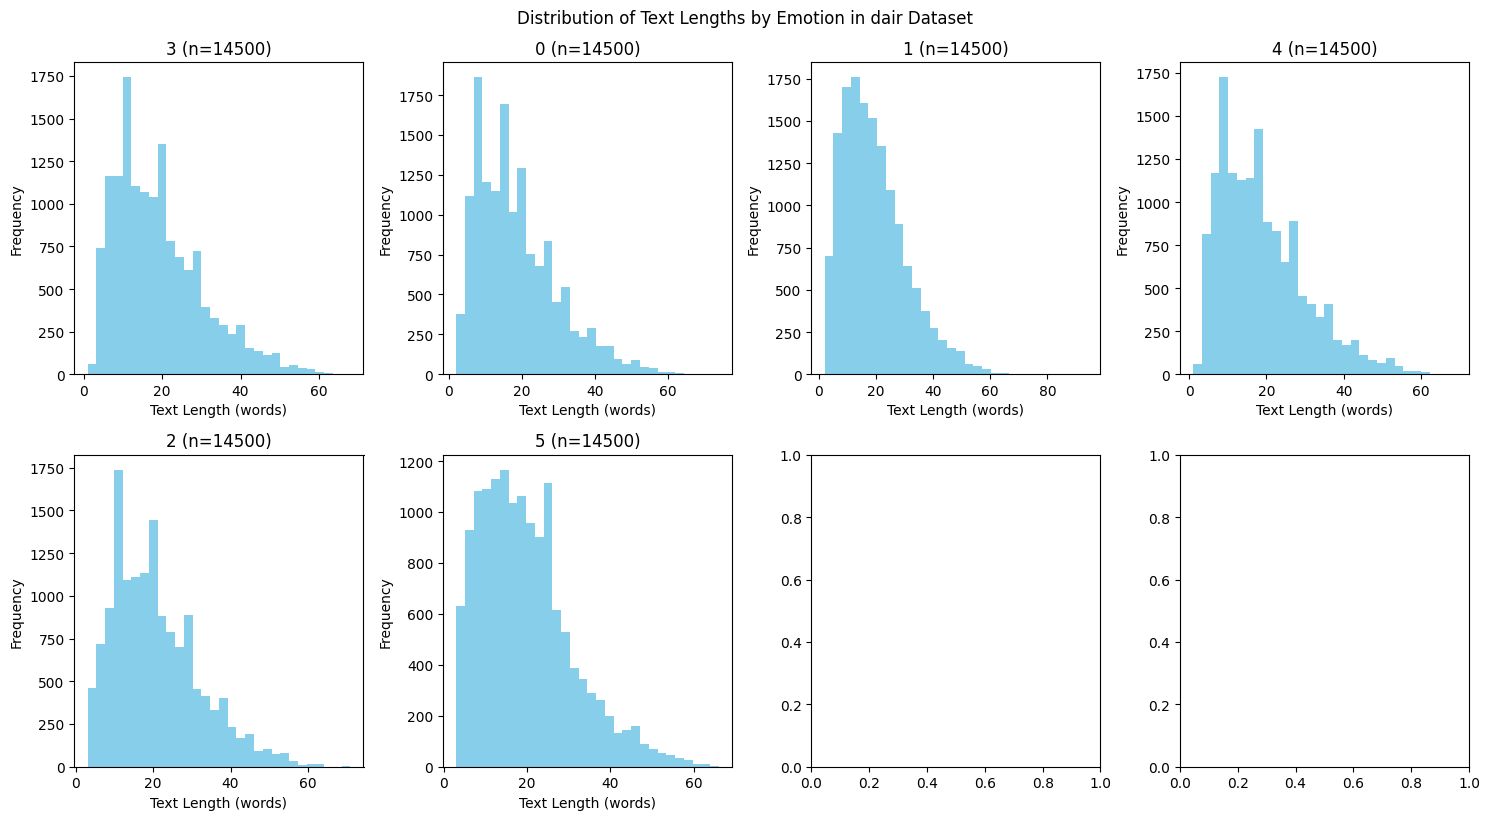

In [ ]:
# Get the list of unique emotions in the dataset
emotions = df_augmented['label'].unique()


# Set up subplots (adjust layout as needed)
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # 2 rows, 4 columns (for 7 emotions)
axes = axes.ravel()  # Flatten the axes array for easy iteration

# Plot histogram of text lengths for each emotion
for i, emotion in enumerate(emotions):
    # Filter text by emotion and compute lengths
    text_lengths = df_augmented[df_augmented['label'] == emotion]['text'].str.split().map(lambda x: len(x))

    # Plot histogram
    axes[i].hist(text_lengths, color='skyblue', bins=30)
    axes[i].set_title(f'{emotion} (n={len(text_lengths)})')
    axes[i].set_xlabel('Text Length (words)')
    axes[i].set_ylabel('Frequency')

# Adjust layout and show
plt.tight_layout()
fig.suptitle('Distribution of Text Lengths by Emotion in dair Dataset', y=1.02)
plt.show()

<Axes: >

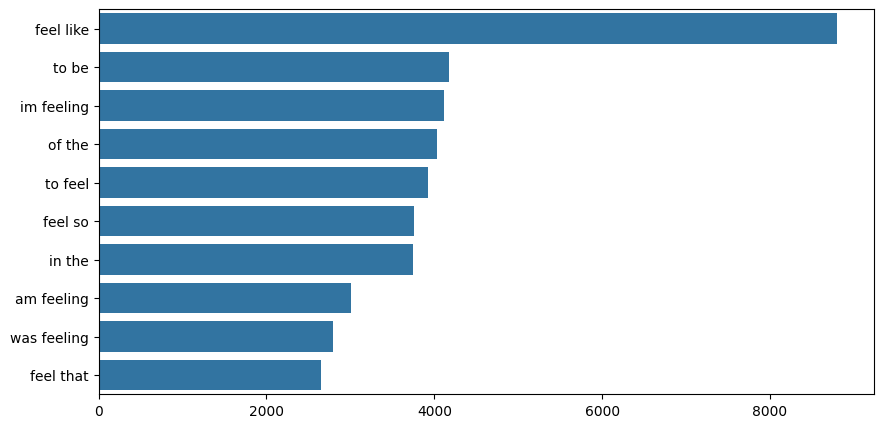

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(df_augmented['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [8]:
from sklearn.model_selection import train_test_split
texts = df_augmented["text"].astype(str).values
labels = df_augmented["label"].values
# Step 1: Hold out final test set (10%)
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)

# Step 2: Split remaining into train (80%) and validation (10%)
# X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42)


code below is new!

In [9]:
from collections import Counter

# Tokenize all texts into words
all_words = ' '.join(X_train).split()
word_counts = Counter(all_words)

# Print the most common words and total unique words
print(f"Total unique words: {len(word_counts)}")
print("Most common words:", word_counts.most_common(10))

Total unique words: 32350
Most common words: [('i', 113453), ('feel', 47495), ('and', 41875), ('to', 38647), ('the', 37073), ('a', 28019), ('feeling', 23107), ('of', 22439), ('that', 21925), ('my', 18688)]


In [10]:
# Set vocabulary size and sequence length
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 55 # adjust based on your text lengths

# Initialize tokenizer and fit on training texts
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
# Pad sequences to uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [11]:
embedding_index = {}
with open("/content/drive/MyDrive/NLP_GLOVE_DAIR/glove.6B.200d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector


In [12]:
word_index = tokenizer.word_index
# len(word_index)
embedding_dim = 200  # based on which GloVe file you're using
num_words = min(MAX_VOCAB_SIZE, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0)}


In [13]:
X_train.shape

(69600,)

In [15]:
from tensorflow.keras.layers import Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_text')

# 1. Embedding Layer with GloVe
embedding_layer = Embedding(
    input_dim=num_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    # input_length=MAX_SEQUENCE_LENGTH,
    trainable=False,  # freeze GloVe weights
    name='embedding'
)(inputs)

# 2. LSTM Layer
x = Bidirectional(LSTM(64, return_sequences=True), name='bilstm')(embedding_layer)
x = SpatialDropout1D(0.3)(x)
x = Bidirectional(LSTM(32, return_sequences=False), name='bilstm1')(x)
# 3. Dropout + Dense
# x = Dropout(0.3, name='dropout1')(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001) ,name='dense1')(x)
x = BatchNormalization(name='batch_norm1')(x)
x = Dropout(0.3, name='dropout2')(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001) ,name='dense2')(x)
x = BatchNormalization(name='batch_norm2')(x)
# 4. Output Layer for 6 classes
outputs = Dense(6, activation='softmax', name='output')(x)

# 5. Model
model = Model(inputs=inputs, outputs=outputs)

# 6. Compile
model.compile(
    loss='sparse_categorical_crossentropy',  # use 'categorical_crossentropy' if labels are one-hot
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

# 7. Summary (optional)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)         │ (None, 55)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 55, 200)        │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm (Bidirectional)          │ (None, 55, 128)        │       135,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 55, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm1 (Bidirectional)         │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm1                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm2                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,194,630 (8.37 MB)

 Trainable params: 194,246 (758.77 KB)

 Non-trainable params: 2,000,384 (7.63 MB)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
import datetime

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Increased patience
    restore_best_weights=True,
    min_delta=0.001  # Minimum change to qualify as an improvement
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,  # Factor by which the learning rate will be reduced
    patience=3,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6  # Lower bound on the learning rate
)

tensorboard = TensorBoard(
    log_dir='./logs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
    histogram_freq=1
)

csv_logger = CSVLogger('training_log.csv', append=True)



In [18]:
# Train the model with delayed unfreeze
history1 = model.fit(   # changed from history
    X_train_pad, y_train,
    epochs=3,
    batch_size=128,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop, model_checkpoint, reduce_lr, tensorboard, csv_logger]
)

Epoch 1/3
544/544 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.3831 - loss: 1.7088 - val_accuracy: 0.7914 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 2/3
544/544 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.8475 - loss: 0.5589 - val_accuracy: 0.9026 - val_loss: 0.3588 - learning_rate: 0.0010
Epoch 3/3
544/544 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9062 - loss: 0.3506 - val_accuracy: 0.9217 - val_loss: 0.2639 - learning_rate: 0.0010


In [19]:
# Train the model with enhanced callbacks
model.get_layer('embedding').trainable = True
model.compile(
    loss='sparse_categorical_crossentropy',  # use 'categorical_crossentropy' if labels are one-hot
    optimizer=Adam(learning_rate=1e-4), #reduced for delayed unfreeze
    metrics=['accuracy']
)
history = model.fit(
    X_train_pad, y_train,
    epochs=50,
    initial_epoch=3,
    batch_size=128,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop, model_checkpoint, reduce_lr, tensorboard, csv_logger]
)

Epoch 4/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.9288 - loss: 0.2525 - val_accuracy: 0.9329 - val_loss: 0.2259 - learning_rate: 1.0000e-04
Epoch 5/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9395 - loss: 0.2149 - val_accuracy: 0.9373 - val_loss: 0.2122 - learning_rate: 1.0000e-04
Epoch 6/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.9416 - loss: 0.1995 - val_accuracy: 0.9380 - val_loss: 0.2025 - learning_rate: 1.0000e-04
Epoch 7/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9419 - loss: 0.1874 - val_accuracy: 0.9415 - val_loss: 0.1909 - learning_rate: 1.0000e-04
Epoch 8/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9452 - loss: 0.1780 - val_accuracy: 0.9426 - val_loss: 0.1853 - learning_rate: 1.0000e-04
Epoch 9/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.9465 - loss: 0.1676 - val_accuracy: 0.9421 - val_loss: 0.1822 - learning_rate: 1.0000e-04
Epoch 10/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/st

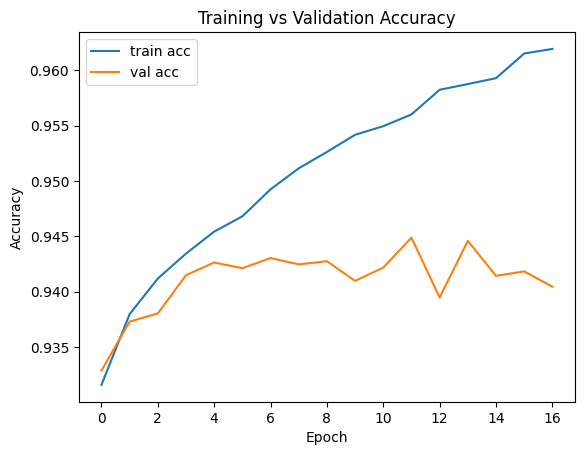

In [20]:


plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


In [21]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Validation Accuracy: {accuracy:.4f}")


544/544 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9436 - loss: 0.1741
Validation Accuracy: 0.9449


In [22]:
y_pred_probs = model.predict(X_test_pad)  # shape: (num_samples, 6)
y_pred = y_pred_probs.argmax(axis=1)     # pick class with highest probability


544/544 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2900
           1       0.98      0.90      0.94      2900
           2       0.92      0.99      0.95      2900
           3       0.94      0.96      0.95      2900
           4       0.94      0.89      0.91      2900
           5       0.92      0.99      0.95      2900

    accuracy                           0.94     17400
   macro avg       0.95      0.94      0.94     17400
weighted avg       0.95      0.94      0.94     17400



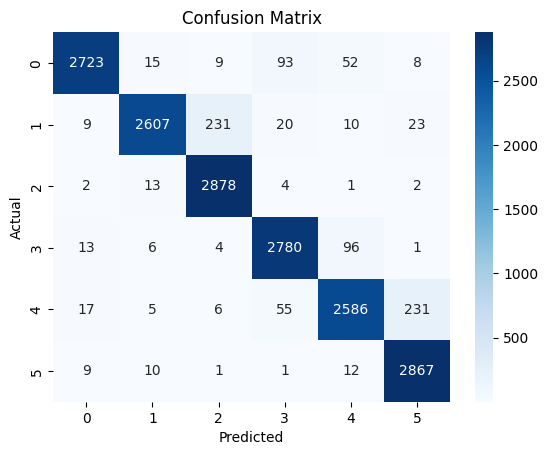

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save("trainable_87k.keras")


In [ ]:
import pickle
with open('tokenizer_trainable_87k.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


Run 1 :

Validation Accuracy: 0.9426

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1450
           1       0.99      0.88      0.93      1450
           2       0.91      0.99      0.95      1450
           3       0.94      0.96      0.95      1450
           4       0.94      0.89      0.92      1450
           5       0.92      0.99      0.95      1450

    accuracy                           0.94      8700
   macro avg       0.94      0.94      0.94      8700
weighted avg       0.94      0.94      0.94      8700
